In [8]:
import torch
import torch.nn as nn
import numpy as np

class ResidualUnit(nn.Module):
    def __init__(self, in_channels, use_bn = False):
        super().__init__()
        self.use_bn = use_bn
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(in_channels)    
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required

    def forward(self, x):
        residual = x
        out = x
        if self.use_bn:
            out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += residual
        return out

class ResidualPipeline(nn.Module):
    def __init__(self, in_channels, n_units, use_bn = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        layers = []
        for i in range(n_units):
            layers.append(ResidualUnit(64, use_bn))
        self.resnet_stack = nn.Sequential(*layers)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_stack(x)
        x = self.relu(x) # not there in original paper
        x = self.conv2(x)
        return x

class ExternalEncoder(nn.Module):
    def __init__(self, ext_dim, map_dim):
        super().__init__()
        self.map_dim = map_dim
        self.fcc1 = nn.Linear(ext_dim, 64, bias = True)
        self.fcc2 = nn.Linear(64, np.prod(map_dim), bias = True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required
        
    def forward(self, x):
        x = self.fcc1(x)
        x = self.relu1(x)
        x = self.fcc2(x)
        x = self.relu2(x)
        return x.view(-1, *self.map_dim)
    
class STResnet(nn.Module):
    def __init__(self, c_channel, p_channel, t_channel, n_residual_units, ext_dim, map_dim, use_bn = False):
        super().__init__()
        self.e_pipe = ExternalEncoder(ext_dim, map_dim)
        self.c_pipe = ResidualPipeline(c_channel, n_residual_units, use_bn)
        self.p_pipe = ResidualPipeline(p_channel, n_residual_units, use_bn)
        self.t_pipe = ResidualPipeline(t_channel, n_residual_units, use_bn)
        # 1 dimension for batch processing, this class cannot process unbatched data
        self.w_c = nn.Parameter(torch.randn(1, *map_dim))
        self.w_p = nn.Parameter(torch.randn(1, *map_dim))
        self.w_t = nn.Parameter(torch.randn(1, *map_dim))
        self.tanh = nn.Tanh()
        
    def forward(self, x_c, x_p, x_t, x_e):
        y_e = self.e_pipe(x_e)
        y_c = self.c_pipe(x_c)
        y_p = self.p_pipe(x_p)
        y_t = self.t_pipe(x_t)
        # Fusion: Eliment wise product (Hadamard Product)
        y = self.w_c*y_c + self.w_p*y_p + self.w_t*y_t
        y = self.tanh(y+y_e)
        return y

In [191]:
# August 10 to 12, 2013 inflow
startdate = '2013-08-10'
dateindex = 0
days = []
flow = np.load('./Datasets/TaxiBJ/TaxiBJ2013.npy')
with open('./Datasets/TaxiBJ/days2013.txt', 'r') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        line = lines[i].strip().split(',')
        if line[0] == startdate:
            dateindex = i
        days.append(line)

# chosen grid
gridx, gridy = 11, 11

start = dateindex*48
end = dateindex*48+3*48
start
end

# original 3 days data here
in_flow = flow[start:end, 0, gridx, gridy]

1440

1584

In [192]:
modelpath = './checkpoints/TaxiBJ/k_fold_stresnet.pt'
if not torch.cuda.is_available():
    model = torch.load(modelpath, map_location=torch.device('cpu'))
else:
    model = torch.load(modelpath)
model.eval();

In [196]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from TaxiBJ import TaxiBJDataset
n_closeness = 4
n_period = 1
n_trend = 1
taxibj_dataset_test = TaxiBJDataset('./Datasets/TaxiBJ/',n_closeness,n_period,n_trend,0.2,False)
mmn = taxibj_dataset_test.mmn_flow

# foundstart, foundend = 0, 0
# ##### CODE: start found at i = 202, end = 346 using proportion 0.2 for TaxiBJDataset(path,close,period,trend,0.2,False)
# for i in range(len(taxibj_dataset_test)):
#     x_c, x_p, x_t, x_e, y = taxibj_dataset_test[i]
#     flow_org = np.zeros((1, 2, 32, 32))
#     flow_org[0,:,:,:] = mmn.inverse_transform(y).cpu().detach().numpy()[:,:,:]
#     compare = np.around(np.squeeze(flow_org, axis=0))
#     if np.array_equal(compare, flow[start]): # if equal to August 10, 2013 data
#         print('start found at i = ' + str(i))
#         foundstart = i
#     if np.array_equal(compare, flow[end]): # if equal to August 12, 2013 data
#         print('end found at i = ' + str(i))
#         foundend = i

foundstart, foundend = 202, 346
# get model predicted data for August 10 to 12, 2013 inflow
pred_in_flow = np.zeros((foundend-foundstart,))
for i in range(foundstart, foundend):
    x_c, x_p, x_t, x_e, _ = taxibj_dataset_test[i]
    x_e = torch.unsqueeze(x_e, 0)
    x_c = torch.unsqueeze(x_c, 0)
    x_p = torch.unsqueeze(x_p, 0)
    x_t = torch.unsqueeze(x_t, 0)    
    y_pred = model(x_c, x_p, x_t, x_e)
    flow_pred = np.zeros((1, 2, 32, 32))
    flow_pred[0,:,:,:] = mmn.inverse_transform(y_pred).cpu().detach().numpy()[:,:,:]
    pred_in_flow[i-foundstart] = flow_pred[0, 0, gridx, gridy]



min: 0.0 max: 1292.0
min: -15.1 max: 36.1
min: 0.0 max: 31.32


In [199]:
InteractiveShell.ast_node_interactivity = "last_expr"

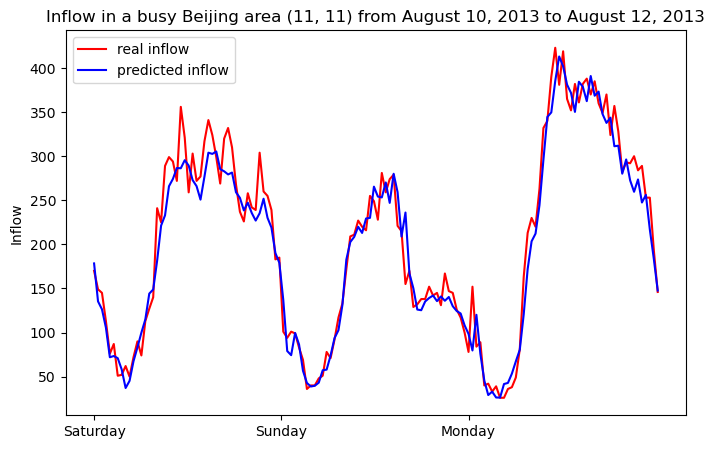

In [200]:
# visualize data inflow comparison here
import matplotlib.pyplot as plt

fig = plt.figure()
# fig.set_size_inches(6.4, 4.8) default
fig.set_size_inches(8, 5)
t = np.linspace(1, 3*48, num=3*48)
plt.plot(t, in_flow, label='real inflow', color='red')
plt.plot(t, pred_in_flow, label='predicted inflow', color='blue')
graphdays = [weekday for date, weekday in days[dateindex:dateindex+3]]
plt.xticks(np.linspace(1, 2*48, num=3), graphdays)
plt.title(f'Inflow in a busy Beijing area ({gridx}, {gridy}) from August 10, 2013 to August 12, 2013')
plt.ylabel('Inflow')
plt.legend(loc='best')
plt.show()